# Introduction to `pydaddy`

`pydaddy` is a Python toolbox to derive stochastic differential equations (SDEs) from time-series data. Given samples of a time-series $x(t)$, `pydaddy` attempts to fit functions $f$ and $g^2$ such that

$$ \frac{dx}{dt} = f(x) + g(x) \cdot \eta(t) $$

where $\eta(t)$ is uncorrelated white noise. The function $f$ is called the _drift_, and governs the deterministic part of the dynamics. $g^2$ is called the _diffusion_ and governs the stochastic part of the dynamics.

In [1]:
import pydaddy

## Initializing a `pydaddy` object

To start analysis, we need to create a `pydaddy` object with our dataset. This will compute the drift and diffusion parts, and generate a summary plot. To initialize a `pydaddy` object, we need to provide the following arguments:
 - `data`: the timeseries data, could be either one or two dimensional. This example will deal with 1D data, see [Getting Started with Vector Data](./2%20-%20Getting%20Started%20with%20Vector%20Data.ipynb) for a 2D example. `pydaddy` assumes that the samples are evenly spaced. `data` should be a list of Numpy arrays; with one array for the scalar case, and two arrays for the vector case.
 - `t`: This could either be scalar, denoting the time-interval between samples, or an array denoting the timestamp of each sample.
 
Following are some useful optional arguments (see [documentation](https://pydaddy.readthedocs.io) for detailed descriptions of every optional argument).

This example uses a sample dataset, loaded using a helper function. For details about data formats and loading/saving data, see [Exporting Data](./5%20-%20Exporting%20Data.ipynb).

| M range              :   (-1.0, 1.0)  |
| M mean               :      0.014     |
| |M| range            :   (0.0, 1.0)   |
| |M| mean             :      0.631     |
| Autocorr time (M)    :       53       |
| (Dt, dt)             :     (1, 1)     |



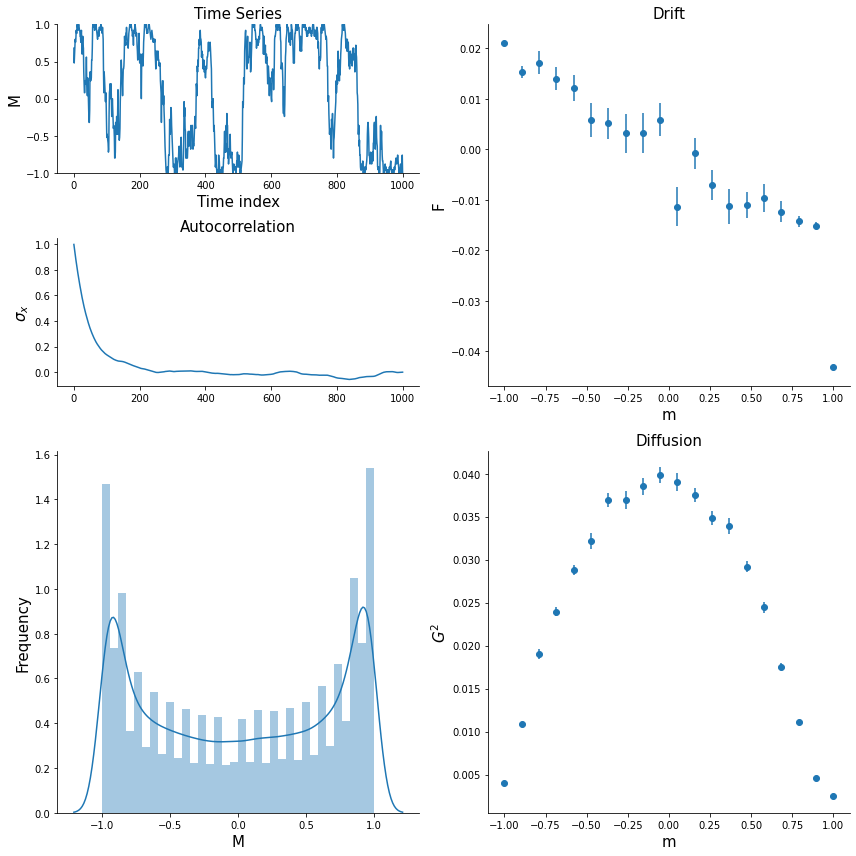

In [2]:
data, t = pydaddy.load_sample_dataset('model-data-scalar-pairwise')
ddsde = pydaddy.Characterize(data, t, bins=20)

`pydaddy.Characterize` initializes a `ddsde` object which can be used for further analysis. It also produces summary plots, showing the time-series, histograms, and the estimated drift and diffusion functions.

`pydaddy` can automatically try to fit polynomial functions if called with argument `fit_functions=True`. However, for best results, it is recommended to do the fitting separately, with some level of manual intervention. See **ANOTHER NOTEBOOK** for more details.

## Recovering functional forms for $f$ and $g$

`pydaddy` has a `fit()` function which can recover functional forms for the drift and diffusion functions, using sparse regression. By default, `pydaddy` fits polynomials (of a specified degree), but it is possible to fit arbitrary functions by specifying a custom library (**SEE ANOTHER NOTEBOOK**).

Two parameters need to be specified during fitting:
 - `order`: The maximum degree of the polynomial to be fitted
 - `threshold`: a _sparsification threshold_, that governs the level of sparsity (i.e. the number of terms in the polynomial). For `threshold=theta`, the fitted polynomial will only have terms with coefficients greater than `theta`. 
 
We can ask `pydaddy` to try to automatically find an appropriate sparsification threshold by calling `fit()` with argument `tune=True`. 

In [3]:
# Fitting with automatic threshold tuning
F = ddsde.fit('F', order=3, tune=True)
print(F)

(-0.021 ± 0.002)x


In [4]:
G = ddsde.fit('G', order=3, tune=True)
print(G)

(0.039 ± 0.000) + (-0.039 ± 0.000)x^2


In the above example, automatic model selection (`tune=True`) sucessfully found the correct threshold. If the data is too noisy, or if `order` is over-estimated, automatic model selection can give poor results. In such cases, good results can be obtained with some manual intervention: see **ANOTHER NOTEBOOK** for more details.

Once the functions are fitted, the `pydaddy` summary plot will show the fitted curves for drift and diffusion, alongside the points.

| M range              :   (-1.0, 1.0)  |
| M mean               :      0.014     |
| |M| range            :   (0.0, 1.0)   |
| |M| mean             :      0.631     |
| Autocorr time (M)    :       53       |
| (Dt, dt)             :     (1, 1)     |

Drift:
(-0.021 ± 0.002)x

Diffusion:
(0.039 ± 0.000) + (-0.039 ± 0.000)x^2



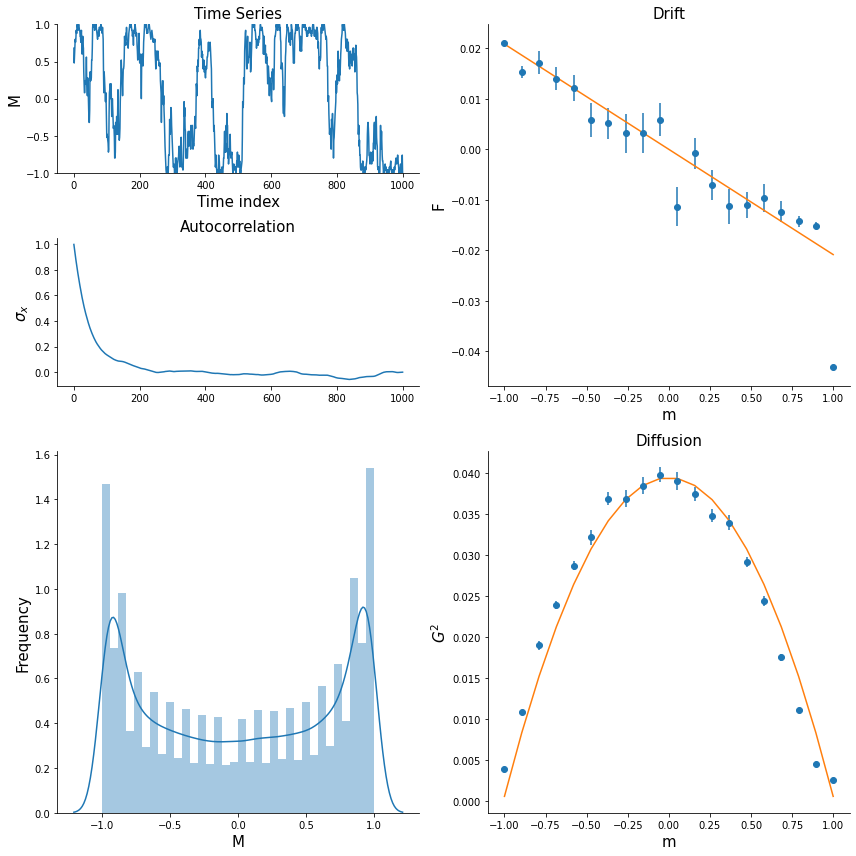

In [5]:
ddsde.summary()

The fitted functions can also be printed individually.

In [6]:
print(ddsde.F)

(-0.021 ± 0.002)x


In [7]:
print(ddsde.G)

(0.039 ± 0.000) + (-0.039 ± 0.000)x^2


`dddsde.F` and `ddsde.G` are, in fact, callable functions: this means that you can call `ddsde.F` or `ddsde.G` with some desired arguments and evaluate the drift or diffusion for that value.

In [8]:
ddsde.F(0.2)

-0.004170417170682441

## Interactive plots for drift and diffusion

To get interactive plots for the drift and diffusion functions, use `ddsde.drift()` or `ddsde.diffusion()`. These will be particularly useful for the 2-D case, where the drift and diffusion plots will be 3-D plots (see [Getting Started with Vector Data](./2%20-%20Getting%20Started%20with%20Vector%20Data.ipynb)).

![](drift.png)

![](diffusion.png)

## Diagnostics

For a drift-diffusion model fit to be valid, the data should satisfy some underlying assumptions. `pydaddy.noise_diagnostics()` allows us to verify if the data satisfies these assumptions.
The function produces 4 plots:

- The distribution of the residuals, which should be a Gaussian.
- QQ plot of the residual distribution, against a theoretical Gaussian distribution of the same mean and variance. Ideally (i.e. if the residuals are Gaussian distributed), all points of this plot should fall on a straight line of slope 1.
- Autocorrelation plot of the residuals. Ideally, the residuals should be uncorrelated, i.e. autocorrelation time should be close to 0.
- The plot of the 2nd and 4th Kramer-Moyal coefficients. Theory dictates that $\text{KM}(4)$ should equal 3 times $\text{KM}(2)$, i.e. the plot should be a straight line of slope 1.

Noise statistics:
	Mean: 0.0056 		Std. Dev.: 0.1999
	Skewness: -0.0552	Kurtosis: 0.0137

Noise autocorrelation time: 0.185 time-steps


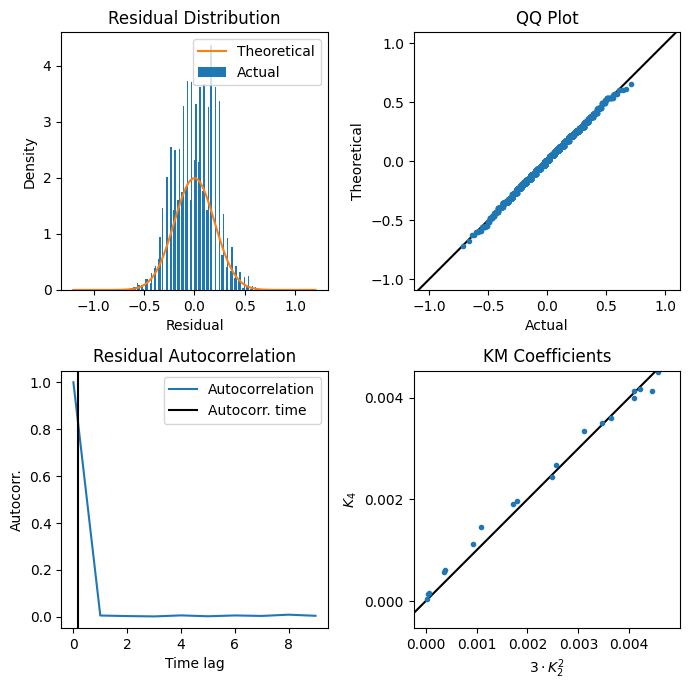

In [11]:
ddsde.noise_diagnostics()

The `fit_diagnostics()` function returns the quality of fits for the fitted drift and diffusion functions. This function prints:
- The fitted polynomials, with standard errors of coefficients.
- $R^2$ value of the fit.
- $R^2$ value of the fit, excluding outliers (points in the bottom 0.1 and top 99.9 percentiles are treated as outliers).

In [12]:
ddsde.fit_diagnostics()


Drift:
 F = (-0.021 ± 0.002)x
    Adjusted R-squared : 0.7908
    Adjusted R-squared (without outliers) : 0.8681

Diffusion:
 G = (0.039 ± 0.000) + (-0.039 ± 0.000)x^2
    Adjusted R-squared : 0.9539
    Adjusted R-squared (without outliers) : 0.9420
